In [ ]:
install.packages("mlbench")
library(mlbench)
data("BostonHousing2")
dat <- BostonHousing2

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



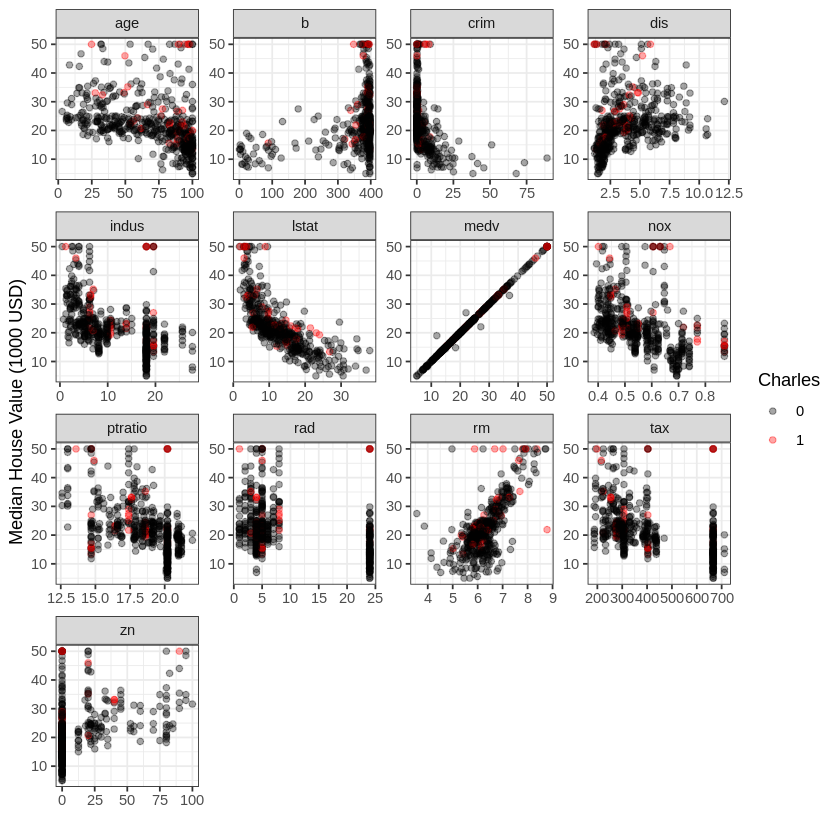

In [ ]:
library(dplyr)
library(ggplot2)
library(tidyr)
p <- dat %>%
  pivot_longer(-all_of(c("town", "tract", "lon", "lat", "cmedv", "chas"))) %>%
  ggplot(aes(x = value, y = cmedv, color = factor(chas))) +
  scale_color_manual(values = c("0" = "black", "1" = "red")) +
  geom_point(alpha = 0.35) +
  facet_wrap(~ name, scales = "free") +
  labs(x = "", y = "Median House Value (1000 USD)", color = "Charles") +
  theme_bw()
print(p)


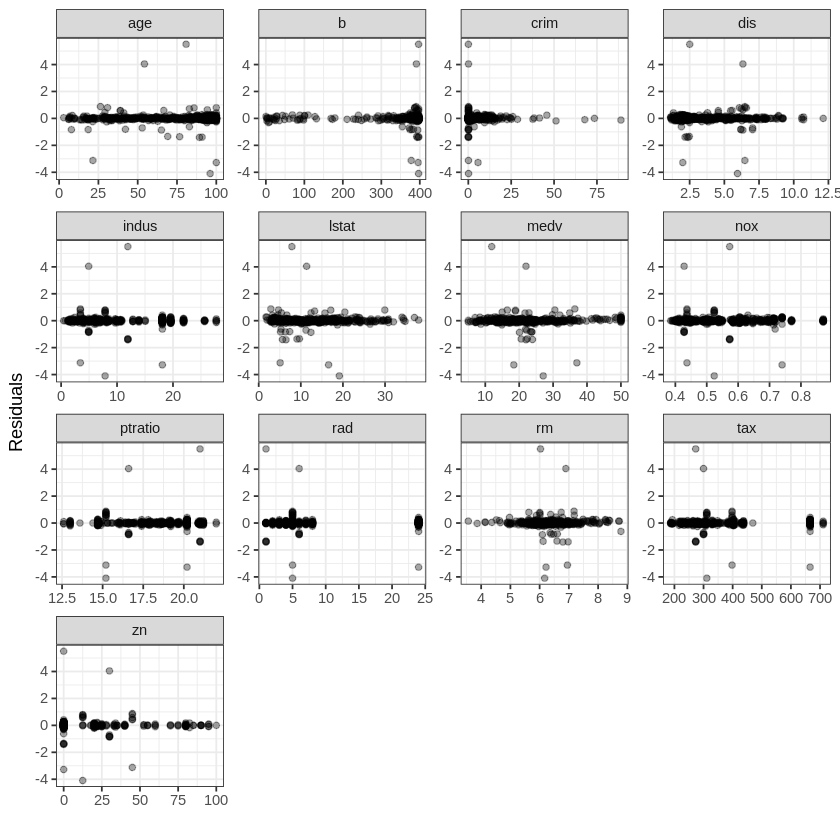

In [ ]:
fit <- lm(cmedv ~ ., data = dat)

residuals_df <- dat %>%
  mutate(residuals = residuals(fit)) %>%
  pivot_longer(-all_of(c("town", "tract", "lon", "lat", "cmedv", "chas", "residuals"))) %>%
  ggplot(aes(x = value, y = residuals)) +
  geom_point(alpha = 0.35) +
  facet_wrap(~ name, scales = "free") +
  labs(x = "", y = "Residuals") +
  theme_bw()
print(residuals_df)


In [ ]:
summary(fit)


Call:
lm(formula = cmedv ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0966 -0.0506  0.0000  0.0509  5.5048 

Coefficients: (5 not defined because of singularities)
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  2.765e+02  2.488e+02   1.111   0.2671    
townAshland                 -6.460e-01  1.418e+00  -0.455   0.6491    
townBedford                  4.788e-01  5.314e-01   0.901   0.3681    
townBelmont                  8.698e-02  2.826e-01   0.308   0.7584    
townBeverly                  3.773e+00  6.125e+00   0.616   0.5382    
townBoston Allston-Brighton  7.661e+00  1.522e+01   0.503   0.6149    
townBoston Back Bay          7.585e+00  1.482e+01   0.512   0.6090    
townBoston Beacon Hill       7.669e+00  1.441e+01   0.532   0.5948    
townBoston Charlestown       6.376e+00  1.352e+01   0.472   0.6375    
townBoston Dorchester        5.117e+00  1.097e+01   0.466   0.6412    
townBoston Downtown       

In [ ]:
hatvals <- hatvalues(fit)
loo_cv_risk <- mean((residuals(fit) / (1 - hatvals))^2)
loo_cv_risk


[1] Inf

In [ ]:
dat <- dat %>%
  mutate(log_crim = log(crim + 1e-6),
         log_dis = log(dis + 1e-6),
         lstat_poly1 = poly(lstat, degree = 2, raw = TRUE)[, 1],
         lstat_poly2 = poly(lstat, degree = 2, raw = TRUE)[, 2],
         lstat_c = pmax(0, lstat + 0.025))

fit_extended <- lm(cmedv ~ crim + zn + indus + chas + nox + rm + age + dis + rad + tax + ptratio + b +
                    lstat + log_crim + log_dis + lstat_poly1 + lstat_poly2 + lstat_c, data = dat)


anova(fit, fit_extended)

hatvals_extended <- hatvalues(fit_extended)
loo_cv_risk_extended <- mean((residuals(fit_extended) / (1 - hatvals_extended))^2)
loo_cv_risk_extended


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,402,104.502,NA,NA,NA,NA
2,489,8245.870,-87,-8141.368,359.9809,0


[1] 17.93286

In [ ]:
library(conformalInference)
funs <- lm.funs()

x.mat <- model.matrix(~ . + log_crim + log_dis + lstat_poly1 + lstat_poly2 + lstat_c, data = dat)
y <- dat$cmedv
new_data.mat <- model.matrix(~ . + log_crim + log_dis + lstat_poly1 + lstat_poly2 + lstat_c, data = new_data)

conf.pred.res <- conformal.pred(x = x.mat, y = y, x0 = new_data.mat,
                                alpha = 0.05, train.fun = funs$train, predict.fun = funs$predict)
conf.pred.res


Warning message in matrix(x0, ncol = p):
“data length [19] is not a sub-multiple or multiple of the number of columns [115]”


ERROR: Error in chol.default(crossprod(x) + lambda[j] * diag(v)): the leading minor of order 2 is not positive
